In [14]:
from typing import Any

import matplotlib.pyplot as plt
import mlflow
import mlflow.artifacts
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from mlflow.store.entities.paged_list import PagedList
from mlflow.tracking import MlflowClient

from cate.infra.mlflow import REMOTE_TRACKING_URI

In [15]:
experiment_name = "biased_data"

In [16]:
mlflow.set_tracking_uri(REMOTE_TRACKING_URI)
client = MlflowClient(tracking_uri=REMOTE_TRACKING_URI)

In [17]:
experiment = client.search_experiments(filter_string=f"name='{experiment_name}'")[0]

In [18]:
def get_child_runs(parent_run_id) -> PagedList:
    return client.search_runs(
        experiment.experiment_id,
        filter_string=f"tags.mlflow.parentRunId='{parent_run_id}'",
    )

In [19]:
def parse_run(run) -> dict[str, Any]:
    _metrics = run.to_dictionary()["data"]["metrics"]
    _tags = run.to_dictionary()["data"]["tags"]
    metrics_keys = [
        "auuc",
        "uplift_at_10",
        "uplift_at_20",
        "uplift_at_30",
        "uplift_at_40",
        "uplift_at_50",
        "uplift_at_60",
        "uplift_at_70",
        "uplift_at_80",
        "uplift_at_90",
    ]
    tags_keys = ["model", "dataset", "random_ratio", "rank"]
    try:
        return {
            **{k: _metrics[k] for k in metrics_keys},
            **{k: _tags[k] for k in tags_keys},
        }
    except:
        return {}


In [20]:
dataset_names = ("criteo", "lenta", "megafon", "hillstorm")
parent_run_ids = [
    "2792b73fda3142e7a9973110a42c754e",
    "63c2354fbd92494ba4a46af185701ab6",
    "70e68a32689a47528a3034ee1ff920e8",
    "79b3da889da94212a670b9a5062182e5",
]


In [21]:
df = None
for dataset_name, parent_run_id in zip(dataset_names, parent_run_ids):
    runs = get_child_runs(parent_run_id)
    data = [parse_run(run) for run in runs]
    _df = pd.DataFrame(data)
    if df is None:
        df = _df
    else:
        df = pd.concat([df, _df])
df = df.reset_index(drop=True)

In [22]:
df

auuc  uplift_at_10  uplift_at_20  uplift_at_30  uplift_at_40  \
0    0.266369      0.001601      0.006251      0.006481      0.005637   
1    0.332884      0.009166      0.006118      0.004345      0.003397   
2    0.399628      0.007618      0.005330      0.006478      0.006654   
3    0.066037      0.001573      0.002148      0.001822      0.002206   
4    0.313910      0.009814      0.004868      0.003459      0.003325   
..        ...           ...           ...           ...           ...   
295  0.187921      0.002490      0.005642      0.004442      0.004021   
296  0.120577      0.000329      0.001769      0.001724      0.001856   
297  0.123819      0.001198      0.001431      0.001099      0.003488   
298  0.070868      0.001835      0.003486      0.002888      0.002400   
299  0.059836      0.001056      0.000870      0.000654      0.001175   

     uplift_at_50  uplift_at_60  uplift_at_70  uplift_at_80  uplift_at_90  \
0        0.005138      0.005642      0.005559      0.004985      0.005184   
1        0.003248      0.003868      0.004164      0.003660      0.003368   
2        0.007395      0.006452      0.006385      0.005924      0.005546   
3        0.003465      0.003589      0.003935      0.004144      0.004621   
4        0.005471      0.004704      0.005180      0.005345      0.004834   
..            ...           ...           ...           ...           ...   
295      0.004650      0.004134      0.004809      0.004971      0.004191   
296      0.004134      0.004797      0.004313      0.004437      0.003724   
297      0.002809      0.003981      0.004009      0.003427      0.003722   
298      0.002553      0.002953      0.003144      0.004278      0.004583   
299      0.001873      0.002182      0.002151      0.002780      0.003604   

         model    dataset random_ratio rank  
0     tlearner  hillstorm          1.0    2  
1     tlearner  hillstorm          1.0    2  
2     tlearner  hillstorm          1.0    2  
3     tlearner  hillstorm          1.0    2  
4     tlearner  hillstorm          1.0    2  
..         ...        ...          ...  ...  
295  drlearner  hillstorm          0.8    2  
296  drlearner  hillstorm          0.6    2  
297  drlearner  hillstorm          0.4    2  
298  drlearner  hillstorm          0.2    2  
299  drlearner  hillstorm          0.0    2  

[300 rows x 14 columns]

In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder_model = LabelEncoder()
label_encoder_dataset = LabelEncoder()

encoded_df = df.copy()
encoded_df["model"] = label_encoder_model.fit_transform(df["model"])
encoded_df["dataset"] = label_encoder_dataset.fit_transform(df["dataset"])

In [24]:
corr = encoded_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [25]:
dataset_flg = df["dataset"] == "hillstorm"
_df = df.loc[dataset_flg, ["uplift_at_20", "model", "random_ratio"]]

<Axes: xlabel='None,random_ratio'>

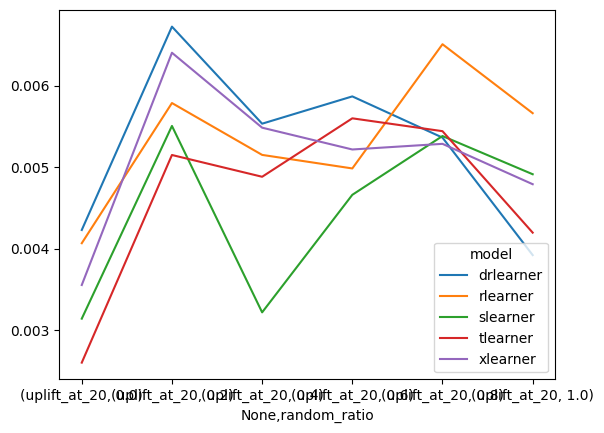

In [32]:
_df.groupby(["model", "random_ratio"]).mean().unstack().T.plot()

In [26]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()

ValueError: Index contains duplicate entries, cannot reshape

In [20]:
dataset_flg = df["dataset"] == "hillstorm"
rank_flg = df["rank"] == "2"
_df = df.loc[dataset_flg & rank_flg, ["uplift_at_20", "model", "random_ratio"]]

In [21]:
_df

uplift_at_20      model random_ratio
90       0.006251   tlearner          1.0
91       0.006118   tlearner          1.0
92       0.005330   tlearner          1.0
93       0.002148   tlearner          1.0
94       0.004868   tlearner          1.0
..            ...        ...          ...
385      0.009727  drlearner          0.0
386      0.002502  drlearner          0.0
387      0.005670  drlearner          0.0
388      0.006495  drlearner          0.0
389     -0.000514  drlearner          0.0

[300 rows x 3 columns]

In [24]:
_df = _df.groupby(["model", "random_ratio"]).median().reset_index()

<Axes: xlabel='random_ratio'>

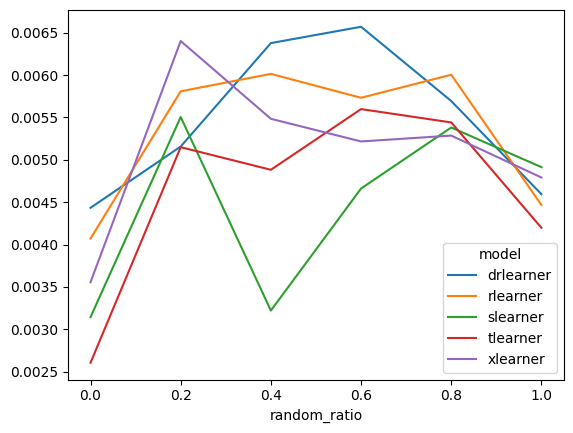

In [25]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()

In [23]:
dataset_flg = df["dataset"] == "lenta"
_df = df.loc[dataset_flg, ["uplift_at_20", "model", "random_ratio"]]

<Axes: xlabel='random_ratio'>

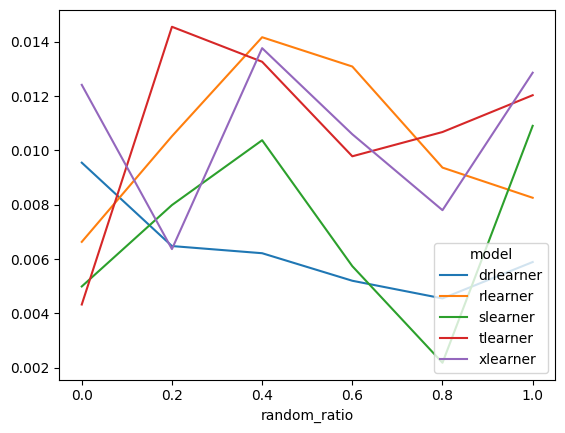

In [24]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()


In [25]:
dataset_flg = df["dataset"] == "megafon"
_df = df.loc[dataset_flg, ["uplift_at_20", "model", "random_ratio"]]

<Axes: xlabel='random_ratio'>

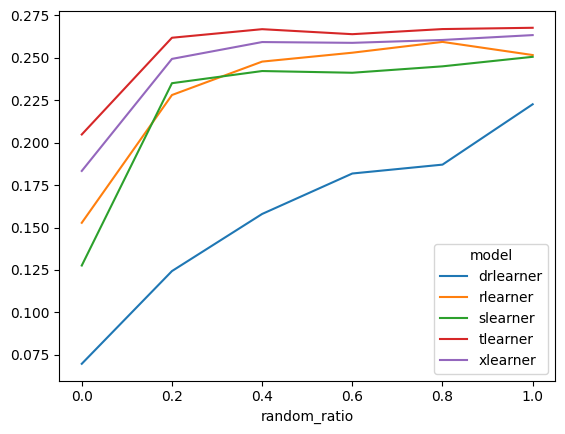

In [26]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()
